#레퍼런스 분석 1

In [ ]:
import pandas as pd
import numpy as np
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from matplotlib import font_manager, rc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
import time

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 15 kB/s 


In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, log_loss
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [ ]:
!pip install gdrive_dataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

from gdrivedataset import loader
file_id = '15qA4X0jTAhYUyiW-rq81rQGXWCC7_CSB'
loader.load_from_google_drive(file_id)

========== files ============

data/sample_submission.csv
data/test.csv
data/train.csv



In [ ]:
!unzip -qq '/content/dataset.zip' # 압축파일 경로

In [ ]:
train = pd.read_csv('/content/data/train.csv')
train.head(3)

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
0,1,28.0,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,3.0,Married,3.0,0,1,0,1.0,Executive,20384.0,0
1,2,34.0,Self Enquiry,3,NaN,Small Business,Female,2,4.0,Deluxe,4.0,Single,1.0,1,5,1,0.0,Manager,19599.0,1
2,3,45.0,Company Invited,1,NaN,Salaried,Male,2,3.0,Deluxe,4.0,Married,2.0,0,4,1,0.0,Manager,NaN,0


In [ ]:
test = pd.read_csv('/content/data/test.csv')
test.head(3)

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,32.0,Company Invited,3,NaN,Small Business,Male,2,5.0,Deluxe,3.0,Married,1.0,0,2,0,1.0,Manager,19668.0
1,2,46.0,Self Enquiry,2,11.0,Small Business,Male,3,NaN,Deluxe,4.0,Married,1.0,1,5,0,1.0,Manager,20021.0
2,3,37.0,Self Enquiry,3,22.0,Small Business,Male,3,4.0,Deluxe,3.0,Married,5.0,0,5,1,0.0,Manager,21334.0


In [ ]:
datasets = (train,test)

상관관계 분석

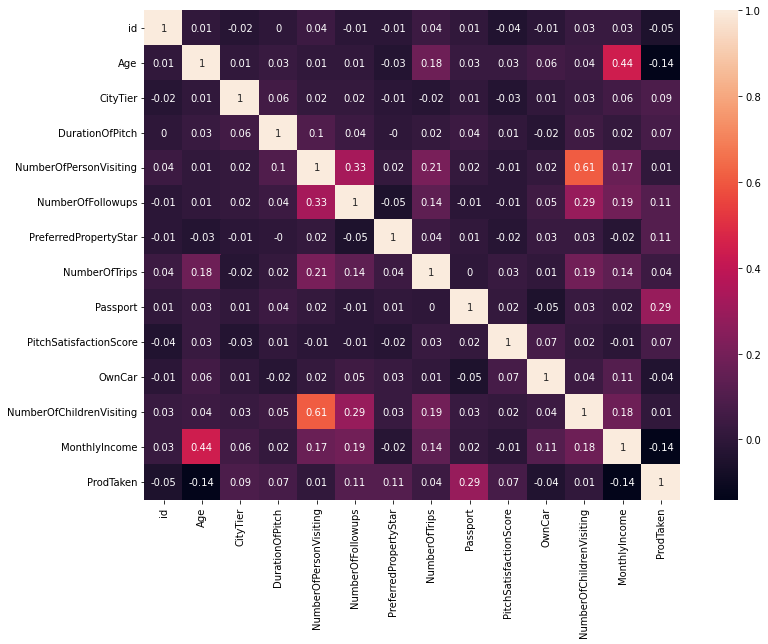

In [ ]:
plt.figure(figsize=(12,9))
sns.heatmap(train.corr().round(2),annot=True);

Age - MonthlyIncome, NumberOfPersonVisiting-NumberOfChildrenVisiting-NumberOfFollowups, Passport-ProdTaken이 높은 연관성을 보임.
연관성을 가진 변수들로 결측치를 처리할 예정임.

이친구는 상관 관계를 이런식으로 구현함. 우리는 여행 패키지 신청에 대해서 중심으로 다루어야 하므로 신청데이터와 상관관계가 있는 부분을 주로 분석하는 과정을 거침.

(여행 패키지 신청vs 달별 수입)

(여행 패키지 신청 vs 나이)

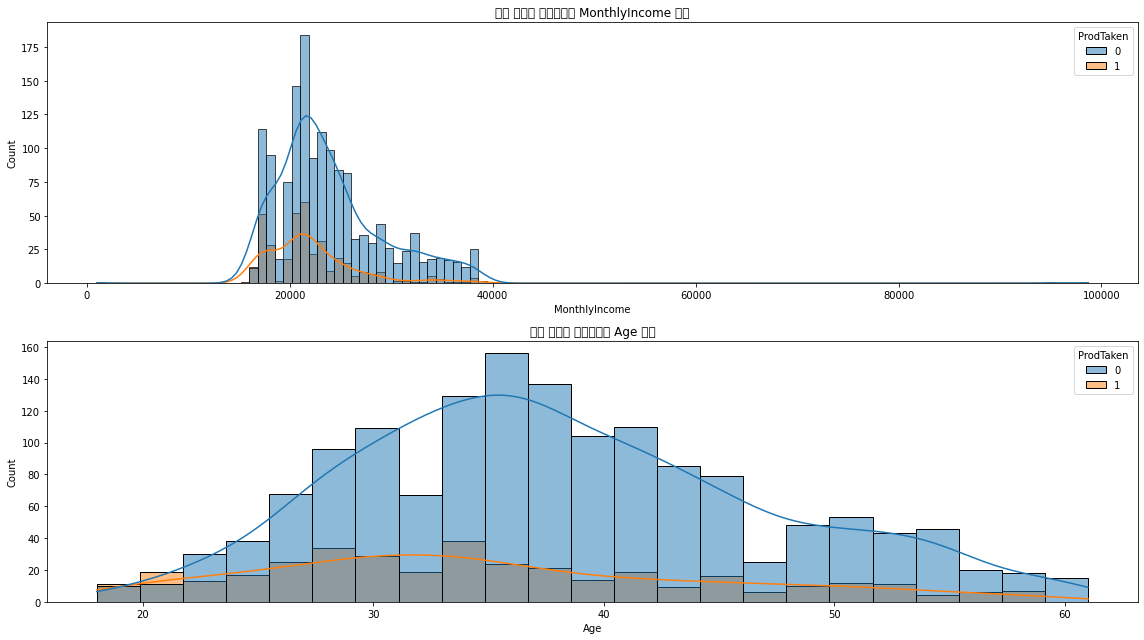

In [ ]:
fig,ax= plt.subplots(2,1,figsize=(16,9))
sns.histplot(data=train,x='MonthlyIncome',hue='ProdTaken',kde=True,ax=ax[0]);
ax[0].set_title('여행 패키지 신청여부별 MonthlyIncome 분포');
sns.histplot(data=train,x='Age',hue='ProdTaken',kde=True,ax=ax[1]);
ax[1].set_title('여행 패키지 신청여부별 Age 분포');
plt.tight_layout()

MonthlyIncome은 이상치도 보이고, 오른쪽으로 치우쳐져 보임. 이상치 확인 후 직급에 따른 평균값으로 수정해줌.

In [ ]:
train.loc[(train.MonthlyIncome<=10000)|(train.MonthlyIncome>=40000)&(train.Designation=='Executive'),]

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
189,190,38.0,Self Enquiry,1,9.0,Large Business,Female,2,3.0,Deluxe,3.0,Single,4.0,1,5,0,0.0,Manager,1000.0,0
604,605,36.0,Self Enquiry,1,11.0,Salaried,Female,2,4.0,Basic,NaN,Divorced,1.0,1,2,1,0.0,Executive,95000.0,0
1338,1339,37.0,Self Enquiry,1,12.0,Salaried,Female,3,5.0,Basic,5.0,Divorced,2.0,1,2,1,1.0,Executive,98678.0,0


In [ ]:
for data in datasets:
    data.loc[(data.MonthlyIncome<=10000)|(data.MonthlyIncome>=40000)&(data.Designation=='Manager'),['MonthlyIncome']] = round(data.loc[data.Designation=='Manager','MonthlyIncome'].mean(),0)
    data.loc[(data.MonthlyIncome<=10000)|(data.MonthlyIncome>=40000)&(data.Designation=='Executive'),['MonthlyIncome']] = round(data.loc[data.Designation=='Executive','MonthlyIncome'].mean(),0)

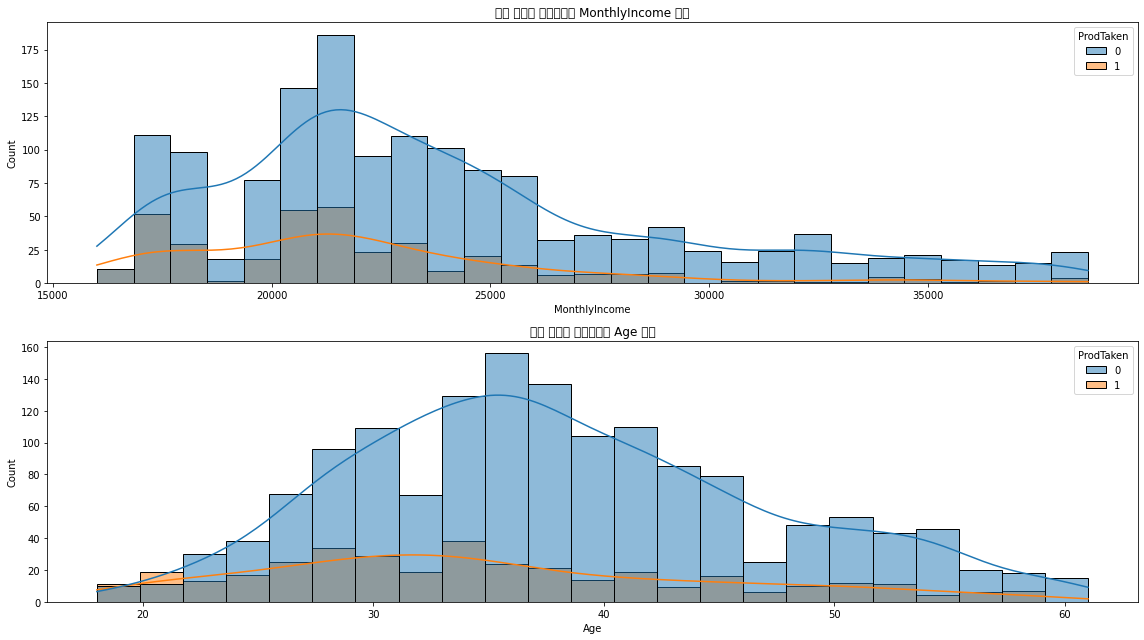

In [ ]:
fig,ax= plt.subplots(2,1,figsize=(16,9))
sns.histplot(data=train,x='MonthlyIncome',hue='ProdTaken',kde=True,ax=ax[0]);
ax[0].set_title('여행 패키지 신청여부별 MonthlyIncome 분포');
sns.histplot(data=train,x='Age',hue='ProdTaken',kde=True,ax=ax[1]);
ax[1].set_title('여행 패키지 신청여부별 Age 분포');
plt.tight_layout()

결측치를 처리함 MonthlyIncome을 직업과 직급에 따른 평균으로 Null값 처리.

In [ ]:
for data in datasets:
    data['MonthlyIncome'].fillna(data.groupby(['Occupation','Designation'])['MonthlyIncome'].transform('mean').round(0),inplace=True)

In [ ]:
print('Train MonthlyIncome 컬럼의 null값:\n{}\n'.format(train.MonthlyIncome.isnull().sum()))
print('Test MonthlyIncome 컬럼의 null값:\n{}'.format(test.MonthlyIncome.isnull().sum()))

Train MonthlyIncome 컬럼의 null값:
0

Test MonthlyIncome 컬럼의 null값:
0


Age는 Income과 가장 상관관계가 높으므로 Income을 6개의 bins로 나눈 새로운 IncomeBin 변수를 생성하고, IncomeBin에 따른 평균으로 Null값을 구함.---> 높은 상관관계를 쪼개서 보기 위해 파생변수로 만들어 봄. 그리고 나이에 대한 결측치도 평균으로 대체함.

In [ ]:
for data in datasets:
    data['IncomeBin'] = pd.qcut(data['MonthlyIncome'],6,labels=[0,1,2,3,4,5])
    data.Age.fillna(data.groupby(['IncomeBin'])['Age'].transform('mean').round(0), inplace=True)
    data['AgeBin'] = pd.qcut(data['Age'],6,labels=[0,1,2,3,4,5])

In [ ]:
print('Train Age 컬럼의 null값:\n{}\n'.format(train.Age.isnull().sum()))
print('Test Age 컬럼의 null값:\n{}'.format(test.Age.isnull().sum()))

Train Age 컬럼의 null값:
0

Test Age 컬럼의 null값:
0


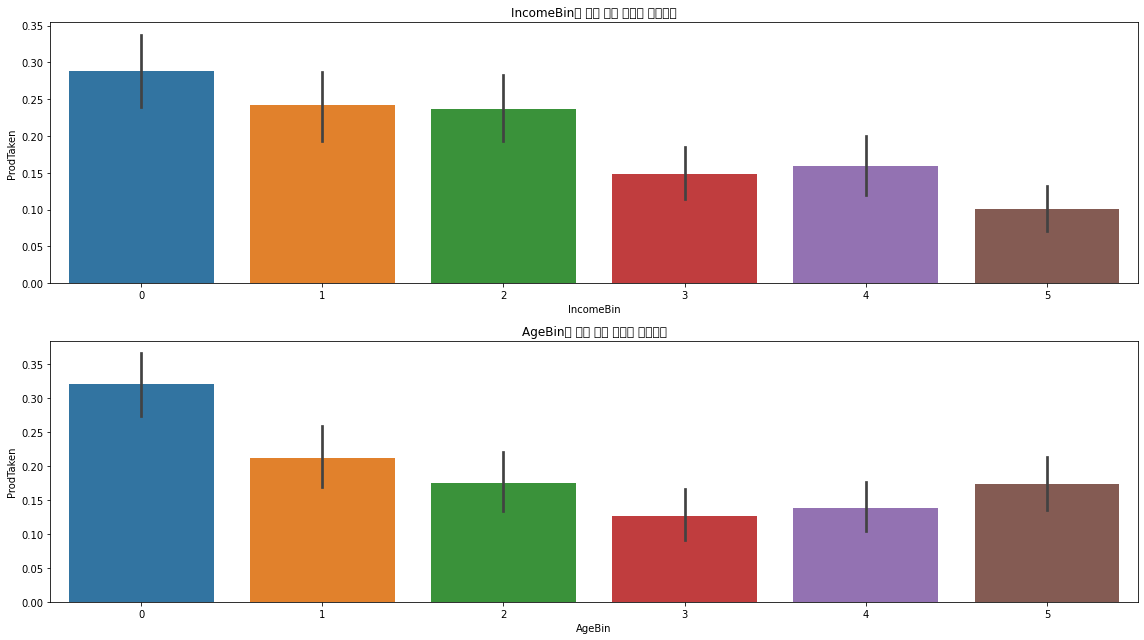

In [ ]:
fig,ax= plt.subplots(2,1,figsize=(16,9))
sns.barplot(data=train,x='IncomeBin',y='ProdTaken',ax=ax[0]);
ax[0].set_title('IncomeBin에 따른 여행 패키지 신청여부')
sns.barplot(data=train,x='AgeBin',y='ProdTaken',ax=ax[1]);
ax[1].set_title('AgeBin에 따른 여행 패키지 신청여부')
plt.tight_layout()

NumberOfTrips, NumberOfChildrenVisiting, NumberOfFollowups

NumberOfTrips, NumberOfChildrenVisitng, NumberOfFollowups의 Null값은 가장 상관성있는 NumberOfPersonVisiting에 따른 최빈값으로 채워줌.

In [ ]:
print('Train NumberOfPersonVisiting 컬럼의 null값:\n{}\n'.format(train.NumberOfPersonVisiting.isnull().sum()))
print('Train NumberOfFollowups 컬럼의 null값:\n{}\n'.format(train.NumberOfFollowups.isnull().sum()))
print('Train NumberOfChildrenVisiting 컬럼의 null값:\n{}\n'.format(train.NumberOfChildrenVisiting.isnull().sum()))
print('Train NumberOfFollowups 컬럼의 null값:\n{}\n'.format(train.NumberOfFollowups.isnull().sum()))

Train NumberOfPersonVisiting 컬럼의 null값:
0

Train NumberOfFollowups 컬럼의 null값:
13

Train NumberOfChildrenVisiting 컬럼의 null값:
27

Train NumberOfFollowups 컬럼의 null값:
13



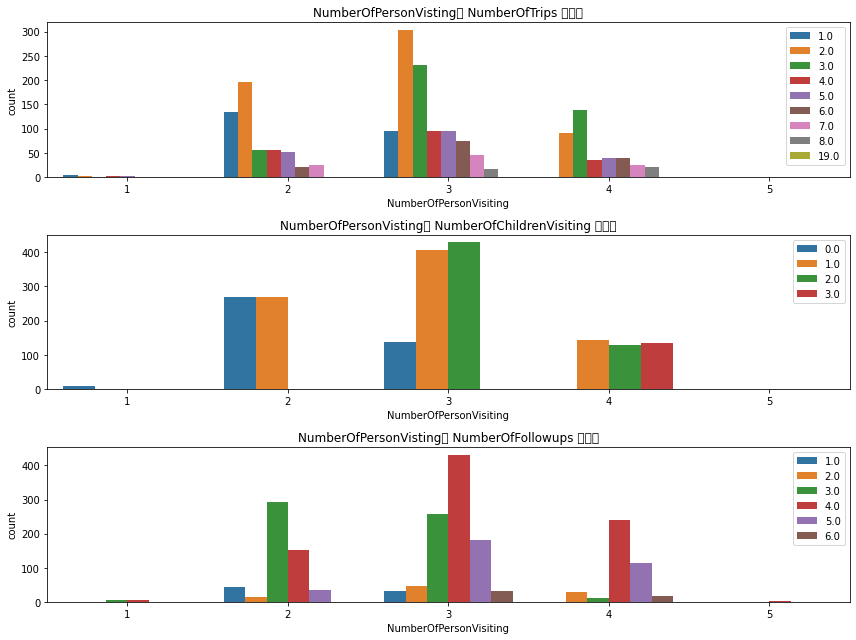

In [ ]:
fig,ax = plt.subplots(3,1,figsize=(12,9))
sns.countplot(data=train, x='NumberOfPersonVisiting',hue='NumberOfTrips',ax=ax[0]);
ax[0].set_title('NumberOfPersonVisting별 NumberOfTrips 최빈수')
ax[0].legend(loc='upper right')
sns.countplot(data=train, x='NumberOfPersonVisiting',hue='NumberOfChildrenVisiting',ax=ax[1]);
ax[1].legend(loc='upper right')
ax[1].set_title('NumberOfPersonVisting별 NumberOfChildrenVisiting 최빈수')
sns.countplot(data=train, x='NumberOfPersonVisiting',hue='NumberOfFollowups',ax=ax[2]);
ax[2].legend(loc='upper right')
ax[2].set_title('NumberOfPersonVisting별 NumberOfFollowups 최빈수')
plt.tight_layout()

In [ ]:
for data in datasets:
    # NumberOfPersonVisiting 그룹별로 NumberOfTrips의 최빈값으로 Null값 fill
    df = data.groupby(['NumberOfPersonVisiting'])['NumberOfTrips'].agg(pd.Series.mode)
    data.NumberOfTrips.fillna(data.NumberOfPersonVisiting.map(df.to_dict()), inplace=True)
    
    # NumberOfPersonVisiting 그룹별로 NumberOfTrips의 최빈값으로 Null값 fill
    df = data.groupby(['NumberOfPersonVisiting'])['NumberOfChildrenVisiting'].agg(lambda x: stats.mode(x)[0][0])
    data.NumberOfChildrenVisiting.fillna(data.NumberOfPersonVisiting.map(df.to_dict()), inplace=True)
    
    # NumberOfPersonVisiting 그룹별로 NumberOfFollowups의 최빈값으로 Null값 fill
    df = data.groupby(['NumberOfPersonVisiting'])['NumberOfFollowups'].agg(lambda x: stats.mode(x)[0][0])
    data.NumberOfFollowups.fillna(data.NumberOfPersonVisiting.map(df.to_dict()), inplace=True)

In [ ]:
print('Train NumberOfPersonVisiting 컬럼의 null값:\n{}'.format(train.NumberOfPersonVisiting.isnull().sum()))
print('Train NumberOfTrips 컬럼의 null값:\n{}'.format(train.NumberOfTrips.isnull().sum()))
print('Train NumberOfFollowups 컬럼의 null값:\n{}'.format(train.NumberOfFollowups.isnull().sum()))
print('Train NumberOfChildrenVisiting 컬럼의 null값:\n{}\n'.format(train.NumberOfChildrenVisiting.isnull().sum()))
print('Test NumberOfPersonVisiting 컬럼의 null값:\n{}'.format(test.NumberOfPersonVisiting.isnull().sum()))
print('Test NumberOfTrips 컬럼의 null값:\n{}'.format(test.NumberOfTrips.isnull().sum()))
print('Test NumberOfFollowups 컬럼의 null값:\n{}'.format(test.NumberOfFollowups.isnull().sum()))
print('Test NumberOfChildrenVisiting 컬럼의 null값:\n{}'.format(test.NumberOfChildrenVisiting.isnull().sum()))

Train NumberOfPersonVisiting 컬럼의 null값:
0
Train NumberOfTrips 컬럼의 null값:
0
Train NumberOfFollowups 컬럼의 null값:
0
Train NumberOfChildrenVisiting 컬럼의 null값:
0

Test NumberOfPersonVisiting 컬럼의 null값:
0
Test NumberOfTrips 컬럼의 null값:
0
Test NumberOfFollowups 컬럼의 null값:
0
Test NumberOfChildrenVisiting 컬럼의 null값:
0


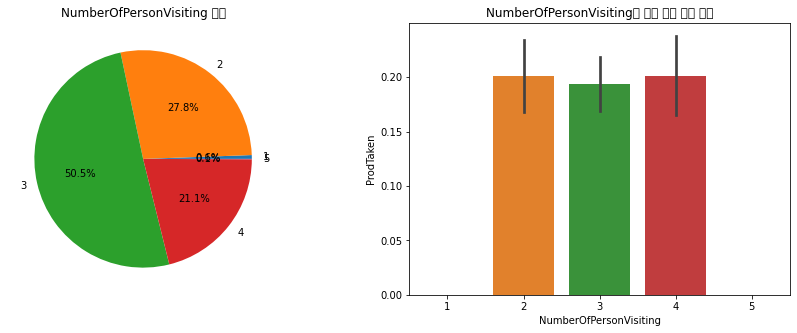

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(train.NumberOfPersonVisiting.value_counts().sort_index().values,labels=train.NumberOfPersonVisiting.value_counts().sort_index().index,autopct='%0.1f%%')
ax[0].set_title('NumberOfPersonVisiting 비율')
sns.barplot(data=train,x='NumberOfPersonVisiting',y='ProdTaken',ax=ax[1]);
ax[1].set_title('NumberOfPersonVisiting에 따른 여행 신청 여부');

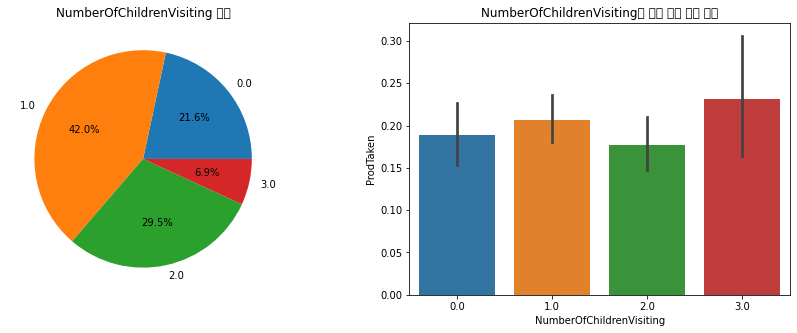

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(train.NumberOfChildrenVisiting.value_counts().sort_index().values,labels=train.NumberOfChildrenVisiting.value_counts().sort_index().index,autopct='%0.1f%%')
ax[0].set_title('NumberOfChildrenVisiting 비율')
sns.barplot(data=train,x='NumberOfChildrenVisiting',y='ProdTaken',ax=ax[1]);
ax[1].set_title('NumberOfChildrenVisiting에 따른 여행 신청 여부');

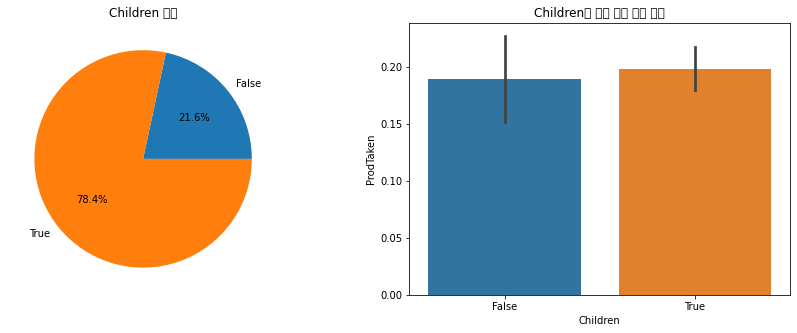

In [ ]:
for data in datasets:
    data['Children'] = data.NumberOfChildrenVisiting.apply(lambda x: False if x==0.0 else True)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(train.Children.value_counts().sort_index().values,labels=train.Children.value_counts().sort_index().index,autopct='%0.1f%%')
ax[0].set_title('Children 비율')
sns.barplot(data=train,x='Children',y='ProdTaken',ax=ax[1]);
ax[1].set_title('Children에 따른 여행 신청 여부');

apply함수를 사용해서 numberofchildern에 있는 0을 제외한 다른 값들을 모두 children이라는 변수로 만들어 적용했다.
그리고 traindata에 children이라는 변수를 추가했다.

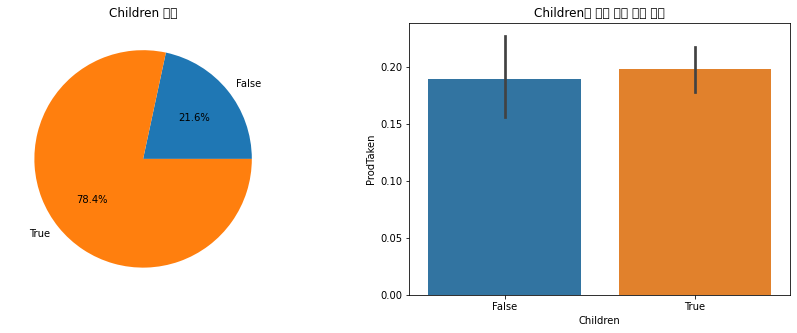

In [ ]:
for data in datasets:
    data['Children'] = data.NumberOfChildrenVisiting.apply(lambda x: False if x==0.0 else True)

fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(train.Children.value_counts().sort_index().values,labels=train.Children.value_counts().sort_index().index,autopct='%0.1f%%')
ax[0].set_title('Children 비율')
sns.barplot(data=train,x='Children',y='ProdTaken',ax=ax[1]);
ax[1].set_title('Children에 따른 여행 신청 여부');

In [ ]:
train.Children

0        True
1       False
2       False
3        True
4       False
        ...  
1950     True
1951     True
1952     True
1953     True
1954    False
Name: Children, Length: 1955, dtype: bool

In [ ]:
test.Children

0        True
1        True
2       False
3        True
4        True
        ...  
2928     True
2929     True
2930     True
2931     True
2932     True
Name: Children, Length: 2933, dtype: bool

Children의 수에 따른 여행 신청에 유의한 차이를 확인하지 못해 Children이 한 명 이상이면 Children 변수에 True를 부여하여 여행 신청 여부를 확인했으나, 큰 차이를 보이지 않음.

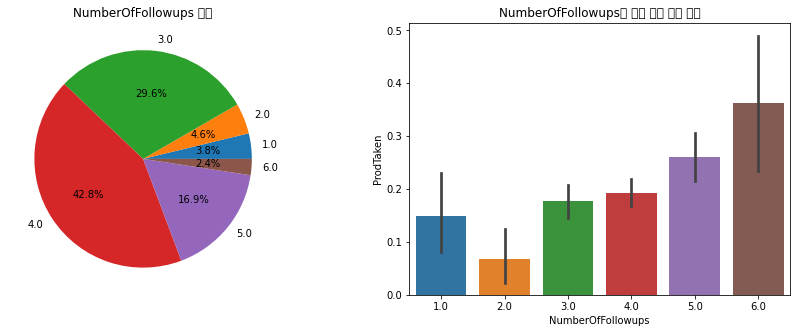

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
ax[0].pie(train.NumberOfFollowups.value_counts().sort_index().values,labels=train.NumberOfFollowups.value_counts().sort_index().index,autopct='%0.1f%%')
ax[0].set_title('NumberOfFollowups 비율')
sns.barplot(data=train,x='NumberOfFollowups',y='ProdTaken',ax=ax[1]);
ax[1].set_title('NumberOfFollowups에 따른 여행 신청 여부');

NumberOfFollowups로 Followupsbins의 새 변수를 생성하여 확률 확인함.

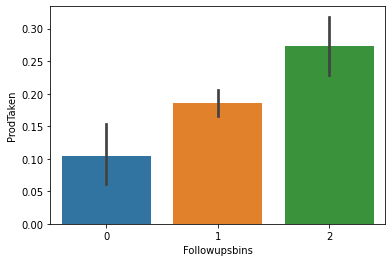

In [ ]:
for data in datasets:
    data['Followupsbins'] = data.NumberOfFollowups.map({1:0,2:0,3:1,4:1,5:2,6:2})
sns.barplot(data=train,x='Followupsbins',y='ProdTaken');

TypeofContact

In [ ]:
train.TypeofContact.isnull().sum()

10

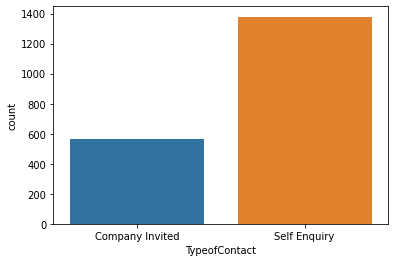

In [ ]:
sns.countplot(data=train,x='TypeofContact')

빈도수가 높은 Self Enquiry로 Null값 채워줌.

In [ ]:
for data in datasets:
    data.TypeofContact = data.TypeofContact.apply(lambda x: 'Self Enquiry' if x is np.nan else x)

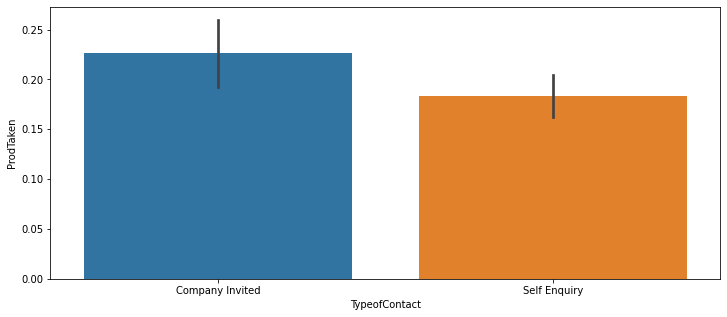

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(data=train,x='TypeofContact',y='ProdTaken');

Self Enquiry 개수가 많지만, 계약이 성사되는 경우는 Company Invited가 더 높음.

DurationOfPitch

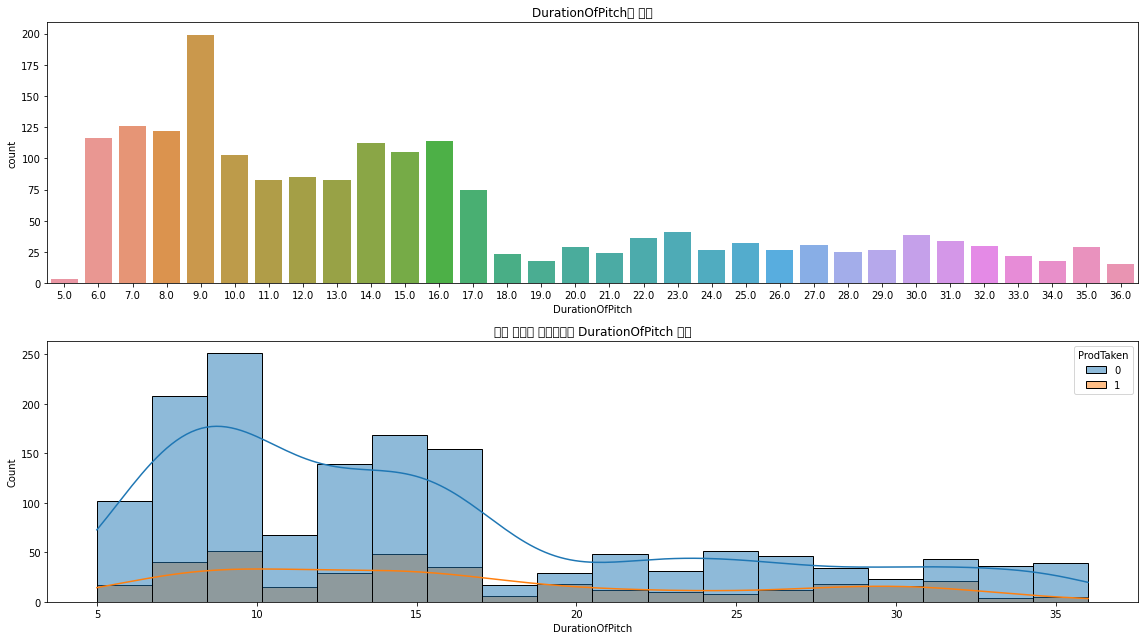

In [ ]:
fig,ax= plt.subplots(2,1,figsize=(16,9))
sns.countplot(data=train,x='DurationOfPitch',ax=ax[0]);
ax[0].set_title('DurationOfPitch의 빈도');
sns.histplot(data=train,x='DurationOfPitch',hue='ProdTaken',kde=True,ax=ax[1]);
ax[1].set_title('여행 패키지 신청여부별 DurationOfPitch 분포');
plt.tight_layout()

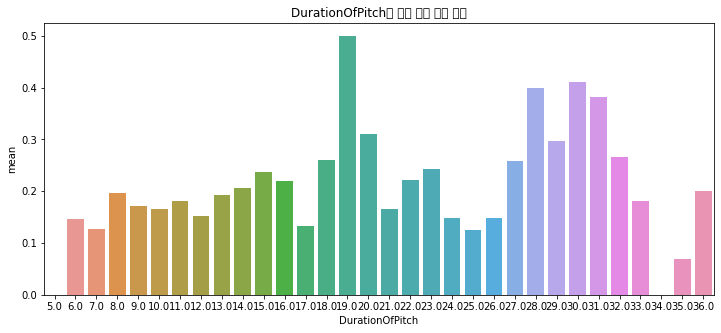

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(data=train.groupby(['DurationOfPitch'])['ProdTaken'].mean().reset_index(name='mean'),x='DurationOfPitch',y='mean');
plt.title('DurationOfPitch별 여행 신청 여부 평균');

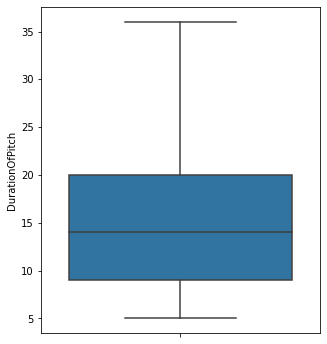

In [ ]:
plt.figure(figsize=(5,6))
sns.boxplot(data=train,y='DurationOfPitch');

In [ ]:
for data in datasets:
    data.DurationOfPitch.fillna(train.DurationOfPitch.median(),inplace=True)

In [ ]:
for data in datasets:
    data['DurationBin'] = pd.qcut(data.DurationOfPitch,4,labels=[0,1,2,3])
    data['LogDurationOfPitch'] = np.log1p(data['DurationOfPitch'])

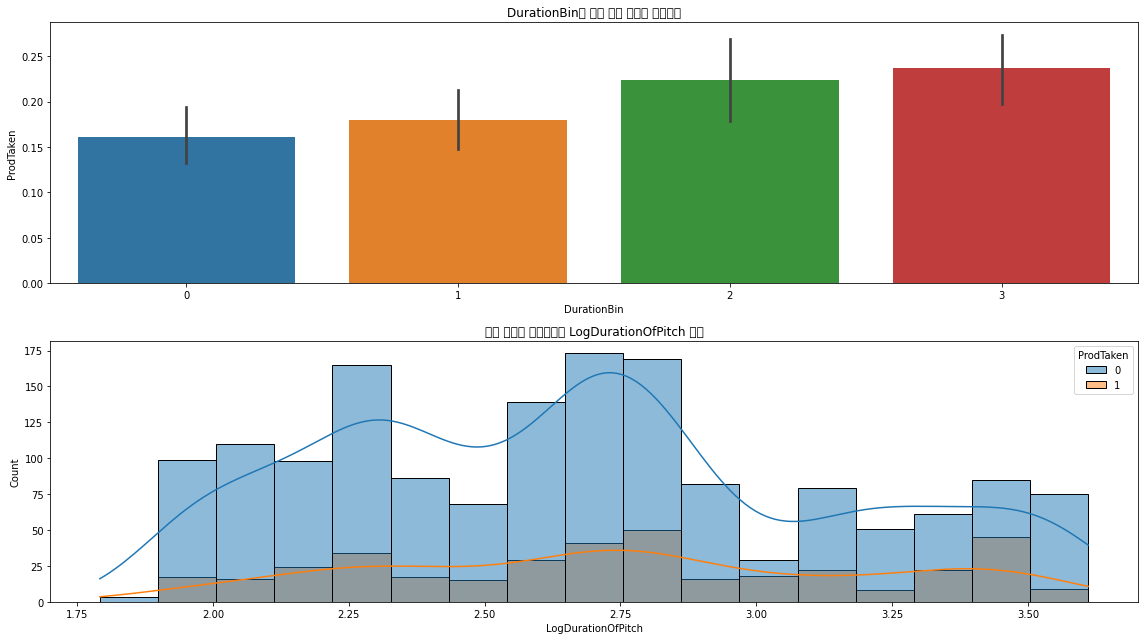

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(16,9))
sns.barplot(data=train,x='DurationBin',y='ProdTaken',ax=ax[0]);
ax[0].set_title('DurationBin에 따른 여행 패키지 신청여부');
sns.histplot(data=train,x='LogDurationOfPitch',hue='ProdTaken',kde=True,ax=ax[1]);
ax[1].set_title('여행 패키지 신청여부별 LogDurationOfPitch 분포');
plt.tight_layout()

DurationBin에 따라 여행 신청 여부의 평균이 차이나는 것을 볼 수 있음.
Log변환을 이용하여, 왜도는 수정됐지만 다봉 분포를 보여 정규분포로 수정되지 않음.

PreferredPropertyStar

In [ ]:
train.PreferredPropertyStar.unique()

array([ 3.,  4.,  5., nan])

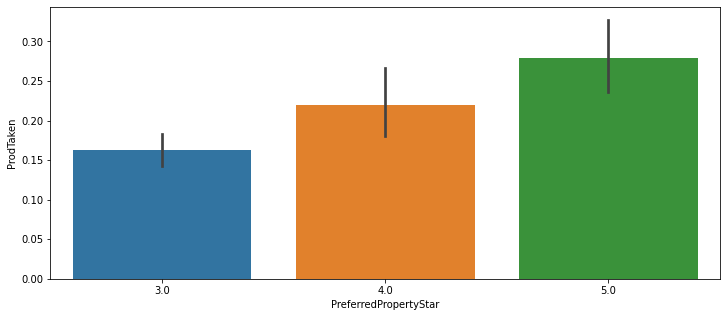

In [ ]:
plt.figure(figsize=(12,5))
sns.barplot(data=train,x='PreferredPropertyStar',y='ProdTaken');

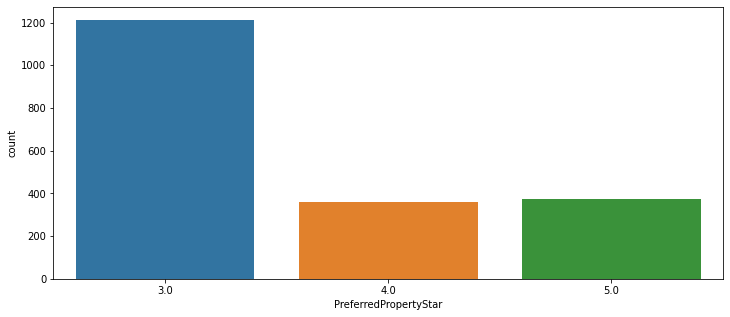

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=train,x='PreferredPropertyStar');

다른 변수들과 상관관계는 없지만 종속변수와는 상관관계가 있음. 최빈값으로 Null값 처리

In [ ]:
for data in datasets:
    data.PreferredPropertyStar.fillna(3.0,inplace=True)

In [ ]:
train

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,...,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken,IncomeBin,AgeBin,Children,Followupsbins,DurationBin,LogDurationOfPitch
0,1,28.0,Company Invited,1,10.0,Small Business,Male,3,4.0,Basic,...,1.0,Executive,20384.0,0,1,0,True,1,1,2.397895
1,2,34.0,Self Enquiry,3,14.0,Small Business,Female,2,4.0,Deluxe,...,0.0,Manager,19599.0,1,1,2,False,1,1,2.708050
2,3,45.0,Company Invited,1,14.0,Salaried,Male,2,3.0,Deluxe,...,0.0,Manager,22742.0,0,3,4,False,1,1,2.708050
3,4,29.0,Company Invited,1,7.0,Small Business,Male,3,5.0,Basic,...,1.0,Executive,21274.0,1,2,0,True,2,0,2.079442
4,5,42.0,Self Enquiry,3,6.0,Salaried,Male,2,3.0,Deluxe,...,0.0,Manager,19907.0,0,1,4,False,1,0,1.945910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1950,1951,28.0,Self Enquiry,1,10.0,Small Business,Male,3,5.0,Basic,...,2.0,Executive,20723.0,0,1,0,True,2,1,2.397895
1951,1952,41.0,Self Enquiry,3,8.0,Salaried,Female,3,3.0,Super Deluxe,...,1.0,AVP,31595.0,0,5,4,True,1,0,2.197225
1952,1953,38.0,Company Invited,3,28.0,Small Business,Female,3,4.0,Basic,...,2.0,Executive,21651.0,0,2,3,True,1,3,3.367296
1953,1954,28.0,Self Enquiry,3,30.0,Small Business,Female,3,5.0,Deluxe,...,2.0,Manager,22218.0,0,2,0,True,2,3,3.433987
